# **Fast Food Marketing Campaign A|B Test Analysis**

## **Position statement for this sprint project:**

In this project, I take on the role of a data scientist assisting our local fast-food chain’s marketing team in analyzing their A/B testing data. The data includes results from three unique marketing campaigns conducted throughout the last quarter of 2024. Based on statistically backed results, the marketing team will implement at least one of these strategies throughout 2025.

## **Objectives:**

* Provide key insights about the fast food chain itself based on the given data
* Understand and describe the A/B test and its goal to the entire marketing team
* Define the target metric on which the statistical inference analysis will be based
* Explain the thought process behind the analysis and decision-making though the way
* Present the results of the analysis
* Offer insights on potential future analyses and opportunities


### **IMPORTING LIBRARIES AND DATASET**

* Library import
* Dataset connection
* Dataset observation



In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import kruskal
from scipy.stats import mannwhitneyu
from scipy.stats import rankdata
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import chisquare 
import itertools

In [43]:
df = pd.read_csv("/Users/kristaps/TC/Projects/keglit-DS.v3.2.2.5/Data/WA_Marketing-Campaign.csv")
df.shape

(548, 7)

In [44]:
df.info()

df.describe()

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


### **DATA CLEANING AND PREPARATION**

* Checking for duplicates and N\A values to ensure that data is relevant
* Observing unique entries in each column
* Renaming column names
* For "Sales" column turning data in full number (float -> int)

**Checking duplicates, nulls and NA values**

In [45]:
df.duplicated().sum()

0

In [46]:
df.isna().sum()

MarketID            0
MarketSize          0
LocationID          0
AgeOfStore          0
Promotion           0
week                0
SalesInThousands    0
dtype: int64

**Unique entries**

In [47]:
df.nunique()

MarketID             10
MarketSize            3
LocationID          137
AgeOfStore           25
Promotion             3
week                  4
SalesInThousands    517
dtype: int64

Information from Kaggle about columns and data in them:
* MarketID: unique identifier for market
* MarketSize: size of market area by sales
* LocationID: unique identifier for store location
* AgeOfStore: age of store in years
* Promotion: one of three promotions that were tested
* week: one of four weeks when the promotions were run
* SalesInThousands: sales amount for a specific LocationID, Promotion, and week. (Currency not specified)

In [48]:
df.apply(lambda x: x.unique())

MarketID                              [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
MarketSize                                     [Medium, Small, Large]
LocationID          [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 10...
AgeOfStore          [4, 5, 12, 1, 10, 15, 6, 22, 8, 19, 11, 13, 3,...
Promotion                                                   [3, 2, 1]
week                                                     [1, 2, 3, 4]
SalesInThousands    [33.73, 35.67, 29.03, 39.25, 27.81, 34.67, 27....
dtype: object

Most important insight from observing data:
* 10 different markets
* 3 market sizes - small, medium and large
* 137 different location id's
* 3 different promotions/marketing campaigns
* there are 548 entries


**Outliers**

In [49]:
def detect_outliers_iqr(dataframe, column):
    Q1 = dataframe[column].quantile(0.25)
    Q3 = dataframe[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = dataframe[(dataframe[column] < lower_bound) | (dataframe[column] > upper_bound)]
    
    return outliers

numerical_columns = df.select_dtypes(include=[np.number]).columns

outlier_report = {}
for col in numerical_columns:
    outliers = detect_outliers_iqr(df, col)
    outlier_report[col] = len(outliers)

outlier_report_df = pd.DataFrame(list(outlier_report.items()), columns=["Column", "Number of Outliers"])
print("Outlier Report:")
print(outlier_report_df)

Outlier Report:
             Column  Number of Outliers
0          MarketID                   0
1        LocationID                   0
2        AgeOfStore                  12
3         Promotion                   0
4              week                   0
5  SalesInThousands                  33


**Renaming columns**

In [50]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [51]:
df.rename(columns={"MarketID": "Market_ID"}, inplace=True)
df.rename(columns={"MarketSize": "Market_size"}, inplace=True)
df.rename(columns={"LocationID": "Location_ID"}, inplace=True)
df.rename(columns={"AgeOfStore": "Store_age"}, inplace=True)
df.rename(columns={"week": "Campaign_week"}, inplace=True)
df.rename(columns={"Promotion": "Campaign"}, inplace=True)
df.rename(columns={"SalesInThousands": "Sales"}, inplace=True)
df["Sales"] = (df["Sales"] * 1000).astype(int)
df.head()

,Market_ID,Market_size,Location_ID,Store_age,Campaign,Campaign_week,Sales
0,1,Medium,1,4,3,1,33730
1,1,Medium,1,4,3,2,35670
2,1,Medium,1,4,3,3,29030
3,1,Medium,1,4,3,4,39250
4,1,Medium,2,5,2,1,27810


### **Conclusion:**
The data has no missing values, no nulls and no duplicates. Sales data needed turning to full number to ensure data is easier to work with. 

There are **548 unique entries** of data, which are divided into **10 market id's**, **137 location id's** and **3 market sizes**. There are **3 different marketing campaign strategies** applied for **4 weeks**.

There are few outliers in data set in age of company and sales data. More deeper look in data is needed to fully understand why they are there and what they mean.


### **EXPLANATORY ANALYSIS**

**Data overlook**

In [52]:
df[["Store_age", "Sales"]].describe()

,Store_age,Sales
count,548.000000,548.000000
mean,8.503650,53466.200730
std,6.638345,16755.220445
min,1.000000,17340.000000
25%,4.000000,42545.000000
50%,7.000000,50200.000000
75%,12.000000,60477.500000
max,28.000000,99650.000000


**There appears to be a relatively large standard deviation in sales, and the minimum and maximum values show a wide spread. This suggests a high variance in sales data, indicating that sales figures fluctuate significantly around the mean**

**Store Market ID classification**

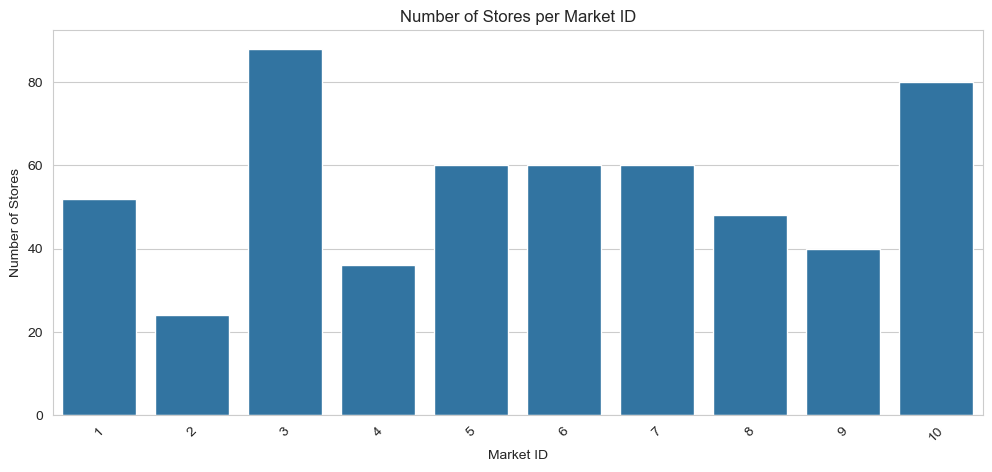

In [53]:
market_id_counts = df["Market_ID"].value_counts()
plt.figure(figsize=(12, 5))
sns.barplot(x=market_id_counts.index, y=market_id_counts.values)
plt.title("Number of Stores per Market ID")
plt.xlabel("Market ID")
plt.ylabel("Number of Stores")
plt.xticks(rotation=45)
plt.show()

The majority of stores fall under Market IDs 3 and 10. These could represent regions or countries, possibly sorted by highest profit or another criterion. Further clarification from the marketing team is needed to confirm their classification.

**Store ages**

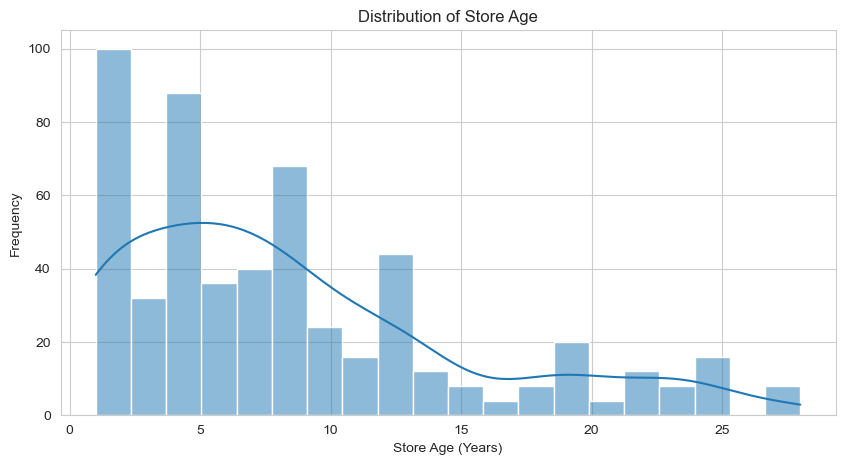

In [54]:
plt.figure(figsize=(10, 5))
sns.histplot(df["Store_age"], bins=20, kde=True,)
plt.title("Distribution of Store Age")
plt.xlabel("Store Age (Years)")
plt.ylabel("Frequency")
plt.show()

Most of the sores in this data set are relatively young with most of them being less than 10 years old. 

**Weekly sales**

In [55]:
weekly_sales_sum = df.groupby("Campaign_week")["Sales"].sum()
print(weekly_sales_sum)

Campaign_week
1    7369310
2    7313960
3    7326018
4    7290190
Name: Sales, dtype: int64


There is a slight deference between 1st and 4th week, but it doesn't look significant. 

**Campaign results**

In [56]:
total_sales_per_campaign = df.groupby("Campaign")["Sales"].sum()
print("Total Sales for Each Campaign:")
print(total_sales_per_campaign)

Total Sales for Each Campaign:
Campaign
1     9993029
2     8897930
3    10408519
Name: Sales, dtype: int64


From the first glims first and third campaign shows better results, but more insight is needed. 

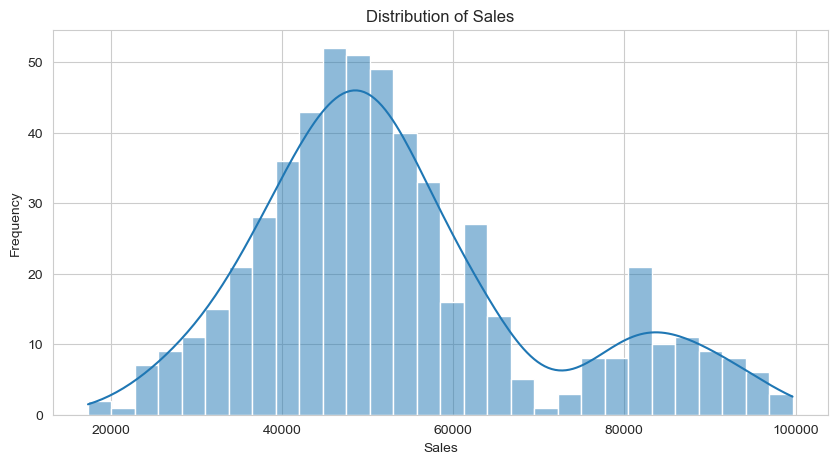

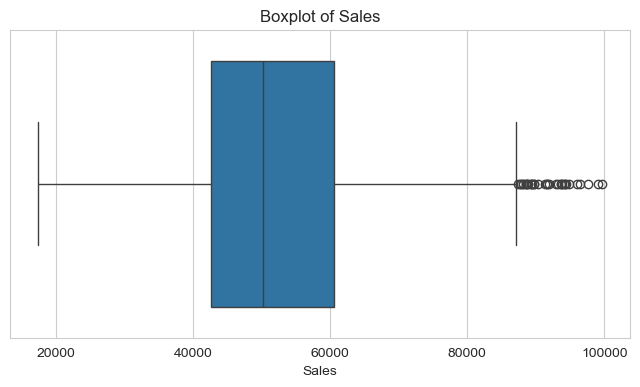

In [57]:
plt.figure(figsize=(10,5))
sns.histplot(df["Sales"], bins=30, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x=df["Sales"])
plt.title("Boxplot of Sales")
plt.show()

Visualizations of the sales data confirm what the standard deviation suggested—there are numerous outliers. The data does not follow a normal distribution and has a right-skewed tail, indicating that outliers could heavily impact the mean. Given this, I have decided that the median is a more appropriate metric for this A/B testing analysis

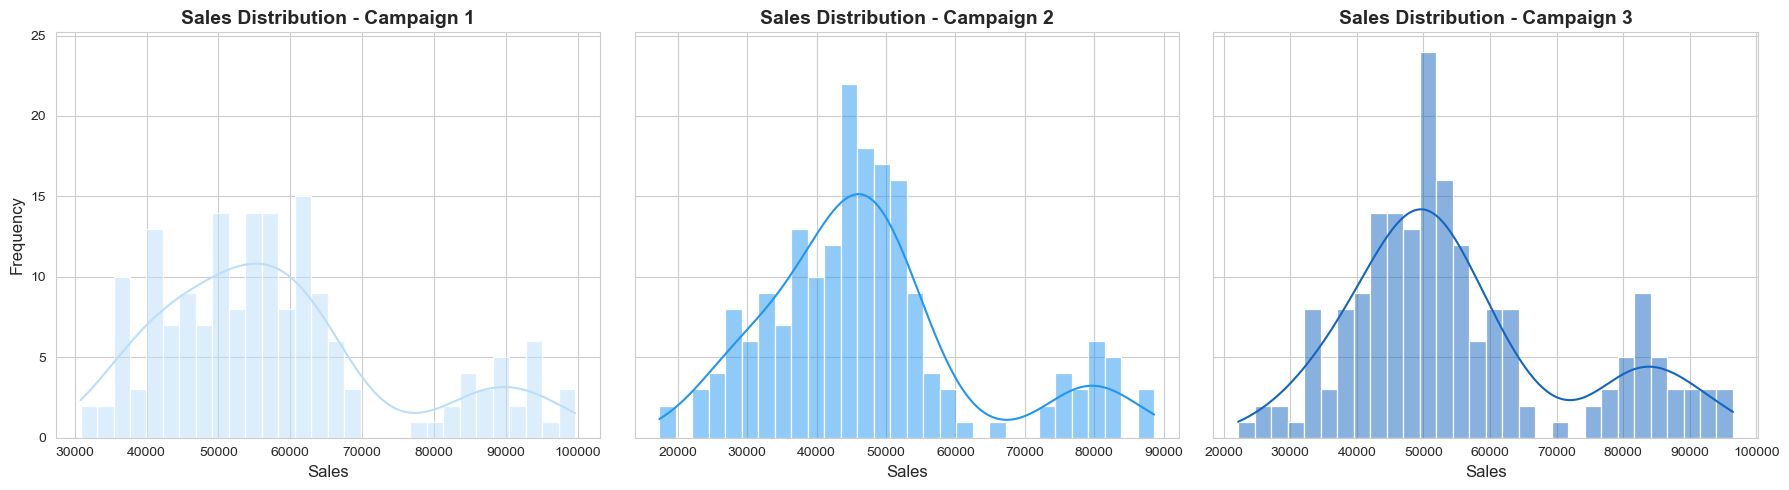

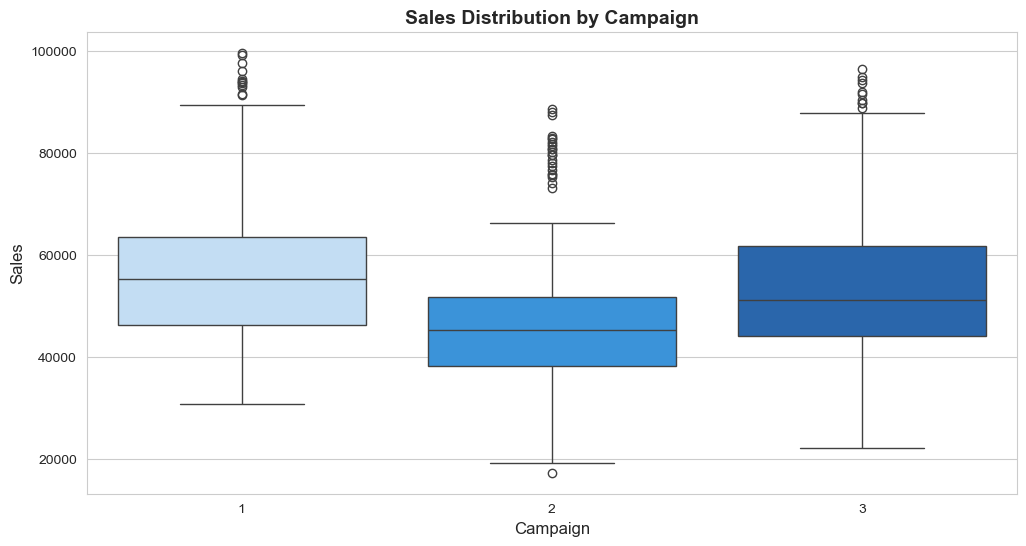

In [87]:
boxplot_colors = ["#bbdefb", "#2196f3", "#1565c0"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, campaign in enumerate(campaigns):
    subset = df[df["Campaign"] == campaign]

    sns.histplot(subset["Sales"], bins=30, kde=True, color=boxplot_colors[i], ax=axes[i])
    axes[i].set_title(f"Sales Distribution - Campaign {campaign}", fontsize=14, fontweight='bold')
    axes[i].set_xlabel("Sales", fontsize=12)
    axes[i].set_ylabel("Frequency", fontsize=12)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x="Campaign", y="Sales", data=df, hue="Campaign", palette=boxplot_colors, legend=False)
plt.title("Sales Distribution by Campaign", fontsize=14, fontweight='bold')
plt.xlabel("Campaign", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.show()

Same observation applies to each campaign sales. 

**Campagne results though each market size**

In [58]:
market_size_counts = df["Market_size"].value_counts()

print("Market Size Distribution:")
for market_size, count in market_size_counts.items():
    print(f"{market_size}: {count}")

Market Size Distribution:
Medium: 320
Large: 168
Small: 60


In [59]:
campaign_distribution = df.groupby("Market_size")["Campaign"].value_counts().unstack()

print("Campaign Distribution by Market Size:\n")
print(campaign_distribution)

Campaign Distribution by Market Size:

Campaign      1    2    3
Market_size              
Large        56   64   48
Medium       96  108  116
Small        20   16   24


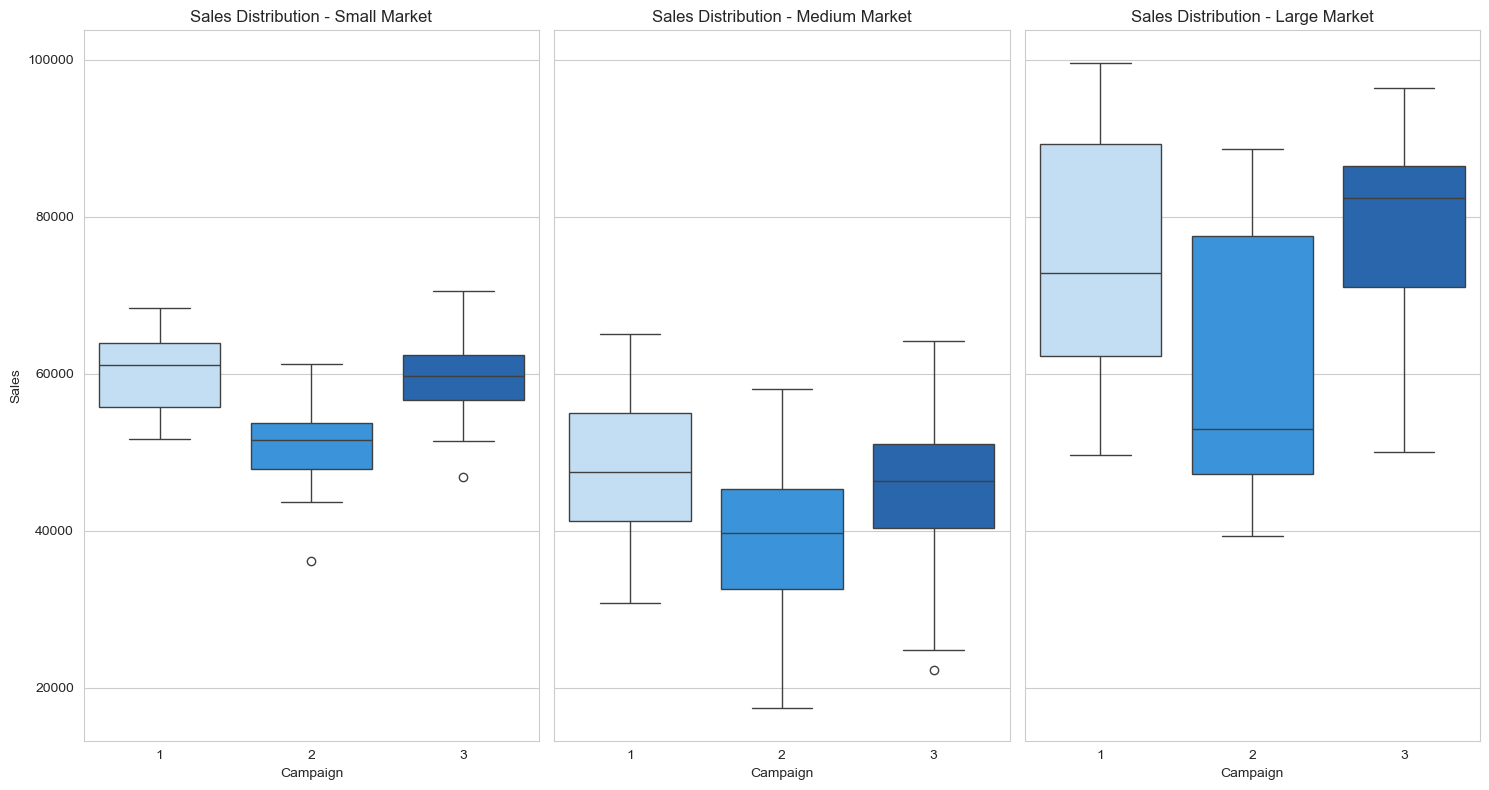

In [78]:
market_sizes = ["Small", "Medium", "Large"]
color_palette = {1: "#bbdefb", 2: "#2196f3", 3: "#1565c0"}

fig, axes = plt.subplots(1, 3, figsize=(15, 8), sharey=True)

for i, market_size in enumerate(market_sizes):
    subset = df[df["Market_size"] == market_size] 
    sns.boxplot(x="Campaign", y="Sales", data=subset, hue="Campaign", palette=color_palette, ax=axes[i], legend=False)
    axes[i].set_title(f"Sales Distribution - {market_size} Market")
    axes[i].set_xlabel("Campaign")
    axes[i].set_ylabel("Sales")

plt.tight_layout()
plt.show()

These observations show:
* Most of the companies fall in medium size group to which most of the campaigns have applied the most
* It looks like 2nd marketing campaign wouldn't be a good choice and would result in smaller sales results. 
* This proves that mean wouldn't be a good choice to compare each campaign.

### **GAOL, TARGET METRIC & HYPOTHESIS**

**GOAL:**

**Determine whether one of the three marketing strategies for a fast-food company led to higher sales over a four-week period**

This goal is based on an A/B test in which the marketing team implemented three different strategies throughout the last quarter of 2024 and collected data on their performance. The statistical insights gained from this analysis will help the marketing team decide which campaign to implement throughout 2025.

**TARGET METRIC (KPI):**

**Median sales over the 4-week period**

The target metric will guide the use of inferential statistics to analyze the data based on our hypothesis. The median is the preferred choice due to the high variance around the mean, making it a more robust measure of central tendency.

An alternative approach would be to use the mean and apply Bootstrapping to account for variability and outliers.



**HYPOTHESIS:**

* **Null Hypothesis (H₀):** The sales distributions are the same across all three marketing campaigns. (MC1 = MC2 = MC3)

* **Alternative Hypothesis (Hₐ):** At least one campaign has a different sales distribution compared to the others. (MC1 != MC2 != MC3 )

### **STATISTICAL INFERENCE ANALYSIS**


I will start Inference analysis by checking sample ration mismatch for this data

**SRM check - Chi-Square test**

In [61]:
group_counts = df["Campaign"].value_counts()  
num_groups = len(group_counts)
expected_ratio = 1 / num_groups
total_users = sum(group_counts)
expected_counts = [total_users * expected_ratio] * num_groups

chi2_stat, p_value = chisquare(f_obs=group_counts, f_exp=expected_counts)
percentage_deviation = (abs(group_counts - expected_counts) / expected_counts * 100).round(2)


srm_table = pd.DataFrame({
    "Campaign": group_counts.index,
    "Observed Count": group_counts.values,
    "Expected Count": expected_counts,
    "Deviation (%)": percentage_deviation.values
})

print(f"SRM Check Results")
print(f"Chi-Square Statistic: {chi2_stat:.4f}")
print(f"P-value: {p_value:.4f}\n")
print(srm_table.to_string(index=False))

SRM Check Results
Chi-Square Statistic: 0.9343
P-value: 0.6268

 Campaign  Observed Count  Expected Count  Deviation (%)
        3             188      182.666667           2.92
        2             188      182.666667           2.92
        1             172      182.666667           5.84


P-value (0.6268) is well above 0.05, meaning any differences in campaign sizes are likely just random variation.

**However,  Capmaign 1 got about 5.84% fewer users than expected, which is a bit higher than the ideal 5% threshold. It’s not a major concern, but something I will keep in mind in further analysis**

**Median data**

Let look at the medians of whole data and each campaign individually. 

In [62]:
weekly_campaign_median_sales = df.groupby(["Campaign_week", "Campaign"])["Sales"].median().unstack()

print("Weekly Median Sales for Each Campaign:")
print(weekly_campaign_median_sales)

Weekly Median Sales for Each Campaign:
Campaign             1        2        3
Campaign_week                           
1              53790.0  46020.0  51010.0
2              55110.0  45750.0  53470.0
3              56190.0  45350.0  50550.0
4              56840.0  44840.0  50050.0


<iframe width="600" height="450" src="https://lookerstudio.google.com/embed/reporting/ade45e1e-5130-4af9-aba9-bfea336406da/page/t268E" frameborder="0" style="border:0" allowfullscreen sandbox="allow-storage-access-by-user-activation allow-scripts allow-same-origin allow-popups allow-popups-to-escape-sandbox"></iframe>

The median sales for the 2nd campaign appear to be the lowest. To further analyze this, we will calculate the confidence intervals for each campaign’s median by bootstrapping 1,000 samples. This will help us understand the variability and reliability of each campaign's median sales.

**Estimated treatment effect**

In [63]:
baseline_campaign = 2
baseline_median = df[df["Campaign"] == baseline_campaign]["Sales"].median()

treatment_effect_results = []
for campaign in df["Campaign"].unique():
    campaign_median = df[df["Campaign"] == campaign]["Sales"].median()
    absolute_difference = campaign_median - baseline_median
    percentage_increase = (absolute_difference / baseline_median) * 100

    treatment_effect_results.append([
        campaign, campaign_median, absolute_difference, round(percentage_increase, 2)
    ])
treatment_effect_df = pd.DataFrame(treatment_effect_results, columns=[
    "Campaign", "Median Sales", "Absolute Difference (vs. Baseline)", "Percentage Increase (%)"
])

treatment_effect_df
treatment_effect_df

,Campaign,Median Sales,Absolute Difference (vs. Baseline),Percentage Increase (%)
0,3,51165.0,5780.0,12.74
1,2,45385.0,0.0,0.00
2,1,55385.0,10000.0,22.03


The 1st campaign had the highest median sales, outperforming the 2nd campaign by 10000 (+22.03%). The 3rd campaign also showed an increase of 5780 (+12.74%) compared to the 2nd campaign. Since the 2nd campaign had the lowest sales, it may be the least effective strategy or could have been impacted by external factors.

**Confidence intervals (CI)**

In [64]:
def bootstrap_ci_median(data, n_bootstrap=1000, ci=95):
    boot_medians = []
    for _ in range(n_bootstrap):
        boot_sample = np.random.choice(data, size=len(data), replace=True)
        boot_medians.append(np.median(boot_sample))

    lower_bound = np.percentile(boot_medians, (100 - ci) / 2)
    upper_bound = np.percentile(boot_medians, 100 - (100 - ci) / 2)
    
    return np.median(boot_medians), (lower_bound, upper_bound)

overall_median, overall_ci = bootstrap_ci_median(df["Sales"].dropna())

campaign_ci_results = {}
for campaign in df["Campaign"].unique():
    campaign_data = df[df["Campaign"] == campaign]["Sales"].dropna()
    median, ci_bounds = bootstrap_ci_median(campaign_data)
    campaign_ci_results[campaign] = {"Median": median, "95% CI": ci_bounds}

print(f"Overall Median Sales: {overall_median}, 95% CI: {overall_ci}\n")
print("Median Sales with Confidence Intervals for Each Campaign:")
for campaign, result in campaign_ci_results.items():
    print(f"Campaign {campaign}: Median = {result['Median']}, 95% CI = {result['95% CI']}")

Overall Median Sales: 50200.0, 95% CI: (49339.0, 51330.0)

Median Sales with Confidence Intervals for Each Campaign:
Campaign 3: Median = 51165.0, 95% CI = (50015.0, 52950.0)
Campaign 2: Median = 45385.0, 95% CI = (44160.0, 47330.0)
Campaign 1: Median = 55460.0, 95% CI = (53679.5, 57200.0)


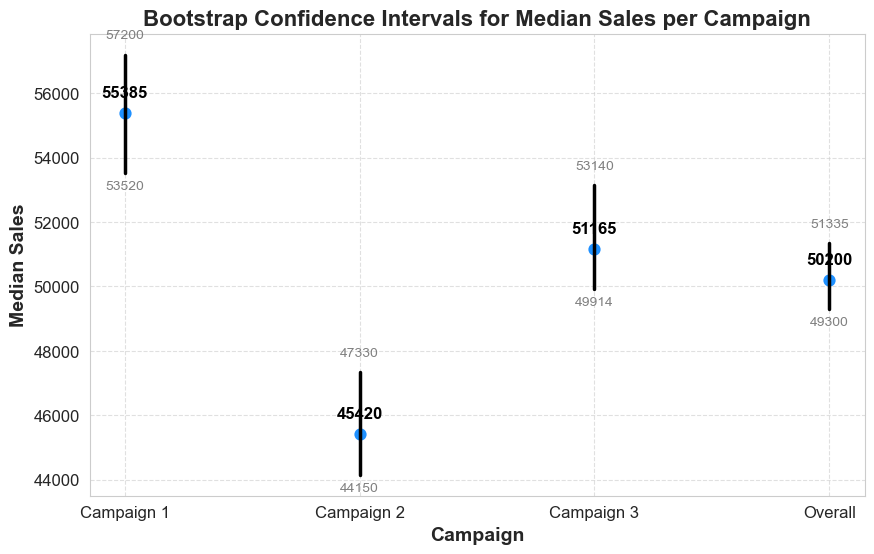

In [65]:
campaigns = ["Campaign 1", "Campaign 2", "Campaign 3", "Overall"]
medians = [55385.0, 45420.0, 51165.0, 50200.0]
lower_bounds = [53520.0, 44150.0, 49914.25, 49300.0]
upper_bounds = [57200.0, 47330.0, 53140.0, 51335.125]

campaign_df = pd.DataFrame({
    "Campaign": campaigns,
    "Median Sales": medians,
    "Lower Bound": lower_bounds,
    "Upper Bound": upper_bounds
})

campaign_df["Campaign"] = pd.Categorical(campaign_df["Campaign"], categories=["Campaign 1", "Campaign 2", "Campaign 3", "Overall"], ordered=True)
campaign_df = campaign_df.sort_values("Campaign")

plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")
sns.pointplot(
    x="Campaign", y="Median Sales", data=campaign_df, capsize=0.2,
    color="dodgerblue", markers="o", err_kws={'linewidth': 3}, linestyle="none"
)

for i, row in campaign_df.iterrows():
    plt.plot([row["Campaign"], row["Campaign"]], [row["Lower Bound"], row["Upper Bound"]],
             color="black", linewidth=2.5)

for i, row in campaign_df.iterrows():
    plt.text(row["Campaign"], row["Median Sales"] + 500, f"{row['Median Sales']:.0f}", 
             ha='center', fontsize=12, fontweight='bold', color="black")

for i, row in campaign_df.iterrows():
    plt.text(row["Campaign"], row["Lower Bound"] - 500, f"{row['Lower Bound']:.0f}", 
             ha='center', fontsize=10, color="gray")
    plt.text(row["Campaign"], row["Upper Bound"] + 500, f"{row['Upper Bound']:.0f}", 
             ha='center', fontsize=10, color="gray")

plt.xlabel("Campaign", fontsize=14, fontweight='bold')
plt.ylabel("Median Sales", fontsize=14, fontweight='bold')
plt.title("Bootstrap Confidence Intervals for Median Sales per Campaign", fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


None of the confidence intervals show statistical significance, meaning the differences in campaign performance may not be conclusive. To further investigate, I should explore other statistical methods to determine if any campaign data is significantly different from the others


Since I have three different groups and the data may not be normally distributed, I plan to apply the Kruskal-Wallis test. If a significant difference is found, I will follow up with Dunn's test to analyze pairwise comparisons and test both the main and subgroup hypotheses.

To confirm that the Kruskal-Wallis test is the appropriate choice, I will first assess the normality of the data. This includes performing a log transformation, visualizing a QQ plot, and conducting the Shapiro-Wilk test to check the p-value, which will determine whether the data follows a normal distribution.

**Normality check**

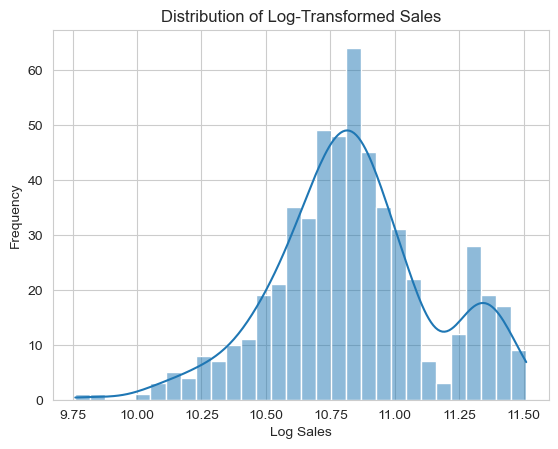

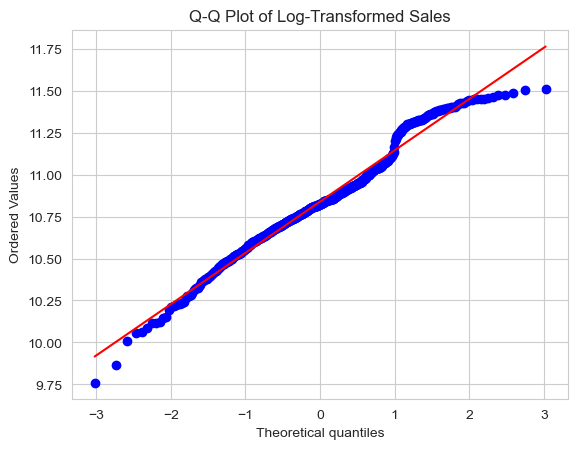

In [66]:
df["Log_Sales"] = np.log(df["Sales"] + 1) 

sns.histplot(df["Log_Sales"], bins=30, kde=True)
plt.title("Distribution of Log-Transformed Sales")
plt.xlabel("Log Sales")
plt.ylabel("Frequency")
plt.show()

stats.probplot(df["Log_Sales"], dist="norm", plot=plt)
plt.title("Q-Q Plot of Log-Transformed Sales")
plt.show()

Even after normalization, the data remains skewed, meaning that an ANOVA test (which assumes normality) would not be the appropriate choice. Based on this, I will proceed with the Kruskal-Wallis test. To confirm this decision, I will apply the Shapiro-Wilk test and examine the p-value to determine whether the data significantly deviates from a normal distribution.

**Shapiro-Wilk test**

In [67]:
stat, p_value = shapiro(df["Log_Sales"])
print(f"Shapiro-Wilk Test Statistic: {stat:.2f}, P-value: {p_value:.2e}")

if p_value < 0.05:
    print("Data is NOT normally distributed (p < 0.05)")
else:
    print("Data is normally distributed (p > 0.05).")

Shapiro-Wilk Test Statistic: 0.98, P-value: 1.35e-06
Data is NOT normally distributed (p < 0.05)


The Shapiro-Wilk test indicates a significant p-value, confirming that the data is not normally distributed. Based on this, the Kruskal-Wallis test is the appropriate choice for analyzing the data.

### **HYPOTHESIS CHECK**

* **Null Hypothesis (H₀):** The sales distributions are the same across all three marketing campaigns. (MC1 = MC2 = MC3)

* **Alternative Hypothesis (Hₐ):** At least one campaign has a different sales distribution compared to the others. (MC1 != MC2 != MC3 )

**Kruskal-Wallis test**

In [68]:
df["Campaign"].value_counts()

Campaign
3    188
2    188
1    172
Name: count, dtype: int64

The Kruskal-Wallis test is not highly sensitive to unequal sample sizes, as long as each group has a reasonable amount of data. As seen before in SRM, there was a small possibility, which should be avoided with this statistical method. 

 Since all groups have more than 100 data points, the test remains statistically reliable, and any differences in sample sizes are acceptable.

In [69]:
group_1 = df[df["Campaign"] == 1]["Sales"]
group_2 = df[df["Campaign"] == 2]["Sales"]
group_3 = df[df["Campaign"] == 3]["Sales"]

stat, p_value = kruskal(group_1, group_2, group_3)

print(f"Kruskal-Wallis Statistic: {stat:.2f}")
print(f"P-value: {p_value:.12f}")

if p_value < 0.05:
    print("At least one group is significantly different")
else:
    print("No significant difference between groups.")

Kruskal-Wallis Statistic: 53.29
P-value: 0.000000000003
At least one group is significantly different


**A high H-value in the Kruskal-Wallis test and an extremely small p-value provide sufficient evidence to reject the null hypothesis (H₀). This means that at least one campaign performed significantly differently from the others.** Based on this result, I will now apply Dunn’s test to further analyze the differences between campaigns.

**Dunn's test**

In [70]:
df["Rank"] = rankdata(df["Sales"])

rank_sums = df.groupby("Campaign")["Rank"].sum()
group_sizes = df["Campaign"].value_counts().sort_index()

N = len(df)  
S2 = (np.sum(df["Rank"] ** 2) - (N * (N + 1) ** 2) / 4) / (N - 1)
S = np.sqrt(S2)  

dunn_results = []
alpha = 0.05 
campaign_pairs = list(itertools.combinations([1, 2, 3], 2))

for pair in campaign_pairs:
    R1, R2 = rank_sums[pair[0]], rank_sums[pair[1]]
    n1, n2 = group_sizes[pair[0]], group_sizes[pair[1]]
    Z = (R1 / n1 - R2 / n2) / np.sqrt(S2 * (1 / n1 + 1 / n2))
    
    
    p_value = 2 * (1 - norm.cdf(abs(Z)))
    adjusted_p_value = p_value * len(campaign_pairs)
    
    dunn_results.append([pair[0], pair[1], round(Z, 2), f"{p_value:.12f}", f"{adjusted_p_value:.12f}",
                         "Yes" if adjusted_p_value < alpha else "No"])

dunn_results_df = pd.DataFrame(dunn_results, columns=[
    "Campaign A", "Campaign B", "Z-score", "P-value (unadjusted)",
    "P-value (Bonferroni adjusted)", "Significant Difference"
])

dunn_results_df

,Campaign A,Campaign B,Z-score,P-value (unadjusted),P-value (Bonferroni adjusted),Significant Difference
0,1,2,7.02,0.000000000002,0.000000000006,Yes
1,1,3,1.97,0.048621997288,0.145865991863,No
2,2,3,-5.17,0.000000236102,0.000000708307,Yes


P-values are adjusted to account for multiple comparisons, as they increase the risk of false positives. The Bonferroni correction is applied by multiplying the p-values by the number of comparisons, making the test more stringent and reducing the likelihood of a Type 1 error.

**The results from Dunn’s test suggest that the alternative hypothesis (Hₐ) is likely true**

**The findings indicate a significant difference for the 2nd campaign compared to the 1st and 3rd, as observed in the EDA. However, it is difficult to determine whether the 1st or 3rd campaign performed significantly better. Based on previous observations, there is a possibility that the 1st campaign had better performance.**

***Its important to point out that there was a small sample ratio mismatch, which could impact results slightly***

### **CONCLUSIONS AND FUTURE SUGGESTIONS**

**Conclusions:**

* Looking at the EDA and Statistical analysis, 1st campaign shown better results in Sales performing the best in all markets. I suggest marketing team to look into my suggestions for future, but from data given I can hugest to use 1st campaign in 2025.

* The Kruskal-Wallis test indicated that at least one campaign performed significantly differently, providing sufficient evidence to reject the Null Hypothesis (H₀). This suggests that the differences observed among the campaigns are unlikely to be due to random chance, warranting further pairwise comparisons to identify where the significant differences lie.

* The 2nd campaign showed a significant difference compared to the other two. However, the 1st and 3rd campaigns did not have a statistically significant difference, meaning their performance was likely similar. Since the 2nd campaign's performance was significantly different, there is evidence to support the Alternative Hypothesis (Hₐ), indicating that at least one campaign performed differently from the other

***Its important to point out that there was a small sample ratio mismatch, which could impact results slightly***

**Suggestions:**

* Since the 2nd campaign stood out, it’s worth looking at why—did it perform worse - comparing expenses, offers, methods etc.
* The 1st and 3rd campaigns had similar results, so tweaking their strategies might help improve future performance for 2025. Maybe combining them would make even better campaign.
* Breaking things down further by market size or store age could give more useful insights about why 1st and 3rd campaign did result better approach
* Backing up previous suggestions - more data provided would result in better decision making for 2025
* Look into campaigns success and sales corelation with companies age


